In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Create pandas DataFrame from .csv file

In [2]:
df = pd.read_csv('cleaned_df.csv', index_col = False)

### Info about our new dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30746 entries, 0 to 30745
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Professional        30746 non-null  object 
 1   ProgramHobby        30746 non-null  object 
 2   Country             30746 non-null  object 
 3   University          30746 non-null  object 
 4   EmploymentStatus    30746 non-null  object 
 5   FormalEducation     30746 non-null  object 
 6   MajorUndergrad      30746 non-null  object 
 7   HomeRemote          30746 non-null  object 
 8   CompanySize         30746 non-null  object 
 9   CompanyType         30746 non-null  object 
 10  YearsProgram        30746 non-null  object 
 11  YearsCodedJob       30746 non-null  object 
 12  CareerSatisfaction  30746 non-null  float64
 13  JobSatisfaction     30746 non-null  float64
 14  Gender              30746 non-null  object 
 15  Race                30746 non-null  object 
 16  Deve

***

## 'Salary' column inspection - this Series will be our target variable for making prediction.

In [4]:
## get only non-missing values from Dataframe
df_no_nan = df.dropna(how='any').reset_index(drop=True)

## make 2 aliases of Series for code simplify
salary = df['Salary']
no_nan_salary = df_no_nan['Salary']

In [5]:
salary.describe().round(2)

count     10353.00
mean      65105.80
std       43458.32
min           0.00
25%       33009.75
50%       57000.00
75%       91774.51
max      248555.95
Name: Salary, dtype: float64

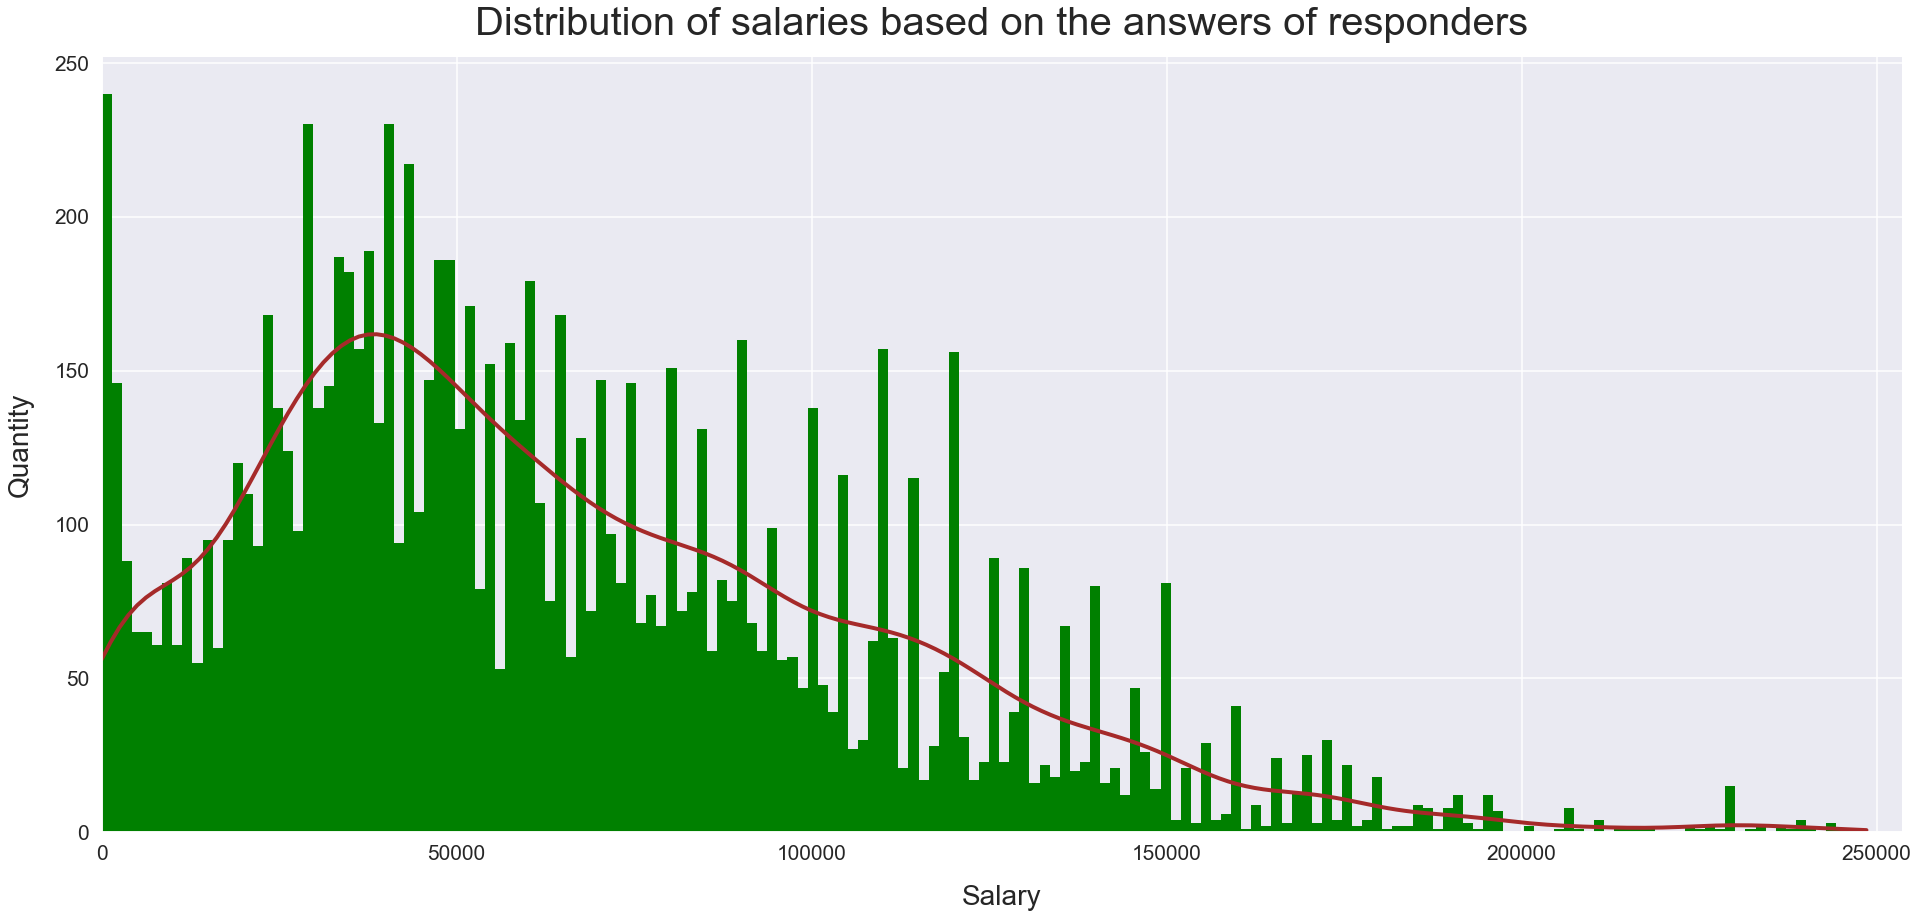

In [6]:
bin_size = np.sqrt(len(salary)).astype('int')

sns.set(context="talk", style="darkgrid")

sns.displot(data=df, x='Salary', bins=bin_size, kind='hist',
            facecolor='green', color='brown', kde=True, 
            line_kws={'lw': 4}, linewidth=0, height=12, aspect=2.2)
plt.xlabel('Salary', fontsize=28, labelpad=21)
plt.ylabel('Quantity', fontsize=28, labelpad=21)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.xlim((salary.min(), salary.max() * 1.02))
plt.title('Distribution of salaries based on the answers of responders',
          fontsize=40, y=1.02)

plt.show()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


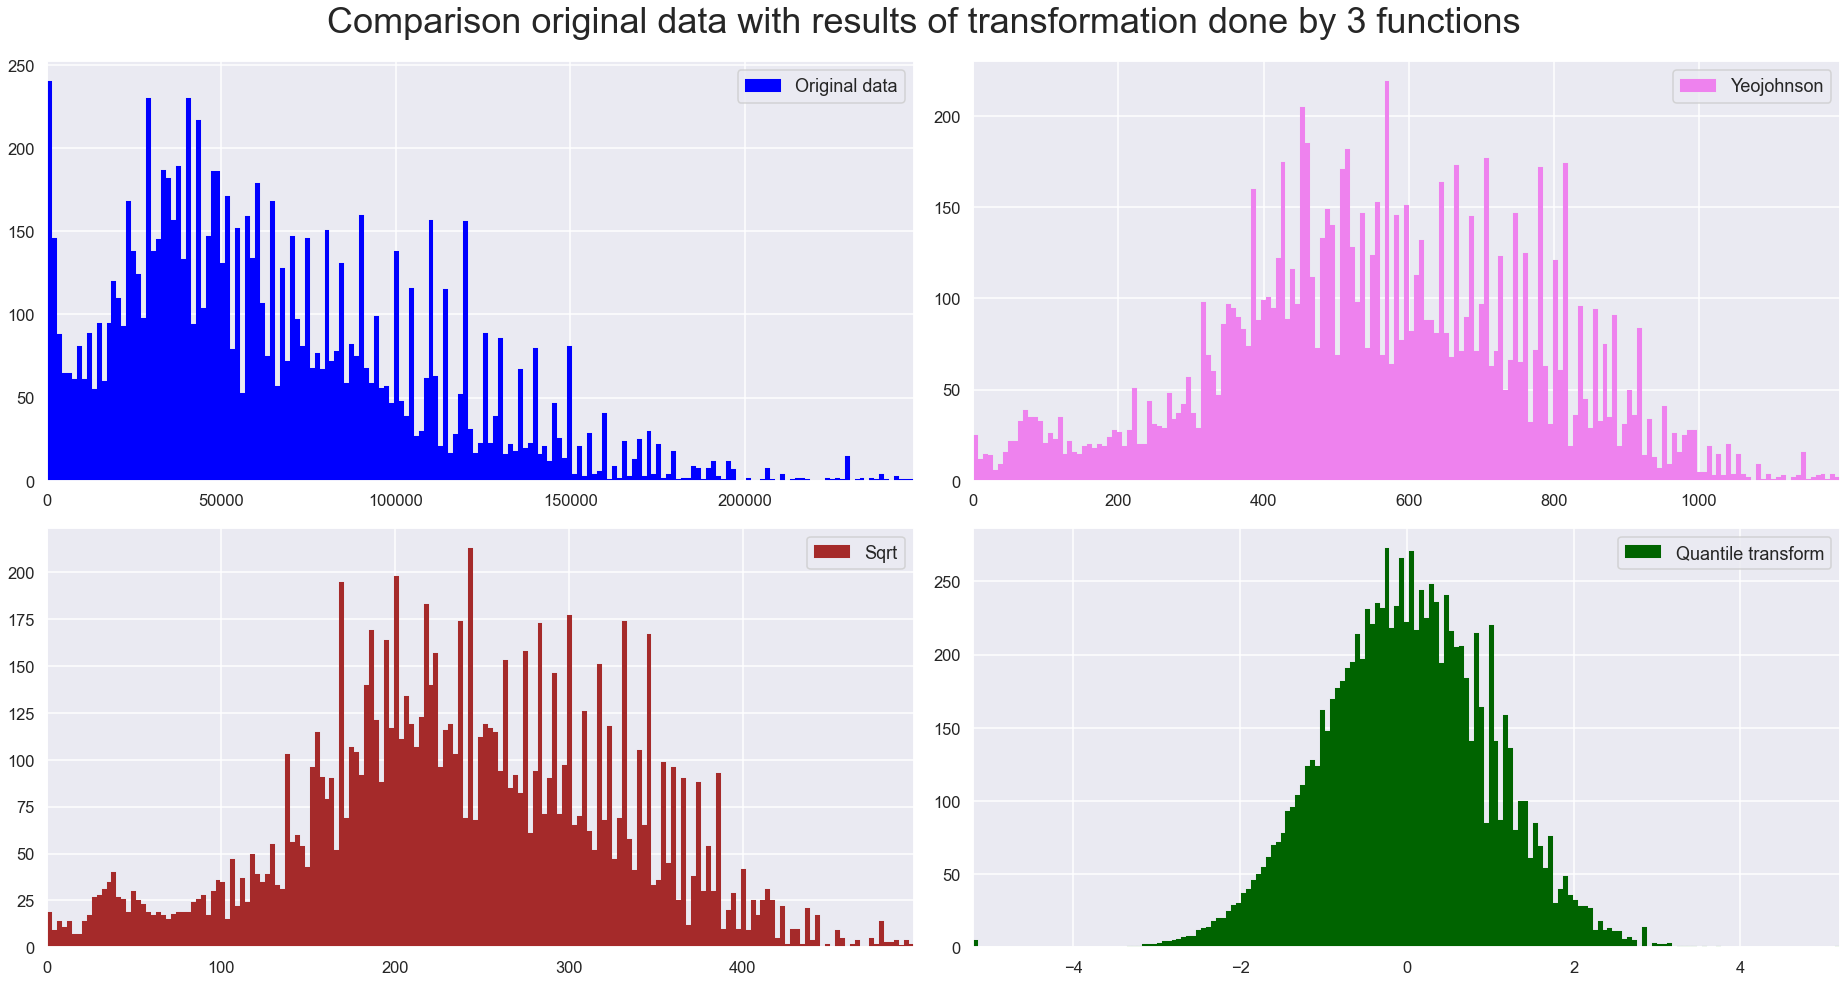

In [7]:
from scipy import stats
from sklearn.preprocessing import QuantileTransformer

funcions_name = ['Original data', 'Yeojohnson', 'Sqrt', 'Quantile transform']

def data_transform(salary_data, column_name):
    ## Return Dataframe after join all columns and present results on the plots
    _ = pd.DataFrame(columns=column_name)
    _[column_name[0]] = salary_data
    _[column_name[1]] = stats.yeojohnson(salary_data)[0].reshape(len(salary_data), 1)
    _[column_name[2]] = np.sqrt(salary_data)
    _[column_name[3]] = QuantileTransformer(subsample=len(salary_data), output_distribution='normal',
                                            n_quantiles=len(salary_data)).fit_transform(
                                            salary_data.values.reshape(-1, 1))    
    return _


salary_transformed = data_transform(no_nan_salary, funcions_name)


## Draw plots to compare results of transformation 'Salary' column with original data
fig, axes = plt.subplots(2, 2, figsize=(26, 14))

axs = [axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]]
colors_list = ['blue', 'violet', 'brown', 'darkgreen']

for inputs, colors, axes in zip(funcions_name, colors_list, axs):
    salary_transformed[inputs].plot.hist(bins = bin_size, color = colors, edgecolor = colors, 
                                            linewidth=0.05, label = inputs, ax = axes)
    axes.set_xlabel(xlabel=None)
    axes.set_ylabel(ylabel=None)
    axes.set_xlim((salary_transformed[inputs].min(), salary_transformed[inputs].max()))
    axes.legend(fontsize = 18)    

plt.suptitle('Comparison original data with results of transformation done by 3 functions', 
             fontsize = 36, y=0.98)
plt.tight_layout()
plt.show()

In [8]:
# Basic stats for above 4 functions:
salary_transformed.describe().T

,count,mean,std,min,25%,50%,75%,max
Original data,10353.0,65105.802698,43458.324355,0.000000,33009.750000,57000.000000,91774.510000,248555.950000
Yeojohnson,10353.0,557.710228,218.645933,0.000000,419.128250,556.666522,712.783884,1194.912756
Sqrt,10353.0,238.500328,90.687324,0.000000,181.685855,238.746728,302.943080,498.553859
Quantile transform,10353.0,-0.000637,1.004557,-5.199338,-0.673578,-0.001090,0.674186,5.199338


---

## Importing libraries which are necessary for properly work the rest of the prediction task.

In [3]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
import joblib
from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.svm import SVR, LinearSVR, NuSVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import Lasso, SGDRegressor, Ridge, HuberRegressor
from sklearn.neighbors import KNeighborsRegressor

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## **1) Calculate regressor model for non-missing values in the target column**

In [10]:
X, y = df_no_nan.drop(['Salary'], axis=1), no_nan_salary
X = X.astype('category')

categorical_features = X.columns
categorical_transformer = Pipeline(steps = [('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers = [('cat', categorical_transformer, categorical_features)])

### Before I start optimize each regressor, I will find the best features from data using 3 regressor based on different algorythm methods:
### 1) support vectors - LinearSVR,
### 2) trees - RandomForest,
### 3) linear model - Lasso.

### I will compare on the plot dependancy between `test_size` and `r_score` values for these regressors

In [11]:
## Range for test_size
ratio = np.linspace(0.10, 0.40, 16)
## Initiate Dataframe with calculated r2_score results for regressors
df_regr_results = pd.DataFrame(data={'test_size': np.round(ratio, 2),
									 'LinearSVR': '',
									 'RandomForestRegressor': '',
									 'Lasso': ''})

regr_list = [LinearSVR(max_iter=1e8), RandomForestRegressor(), Lasso(max_iter=1e8)]


def split_dataset(ratio):
	return train_test_split(X, y, test_size=np.round(ratio, 2), random_state=42)

In [ ]:
def dependence_of_r2_score_on_testsize(regr):
    for i in df_regr_results['test_size'].values:
        X_train, X_test, y_train, y_test = split_dataset(i)

        ## Index in Dataframe to insert r2_score value
        _ = df_regr_results[df_regr_results['test_size']==i].index
        
        # prepare the model with target scaling
        model = TransformedTargetRegressor(regressor=regr, transformer=QuantileTransformer(output_distribution="normal"))
        pipe = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])
        pipe.fit(X_train, y_train)
        
        ## Regressor name and its r2_score to put into Dataframe
        r2_score = round(pipe.score(X_test, y_test), 3)
        regr_name = regr.__class__.__name__
        df_regr_results.loc[_, regr_name] = r2_score
        
    return df_regr_results


for val in regr_list:
    dependence_of_r2_score_on_testsize(val)

df_regr_results

In [12]:
#df_regr_results.to_csv('regr_results.csv', index_label=False)
df_regr_results = pd.read_csv('regr_results.csv')

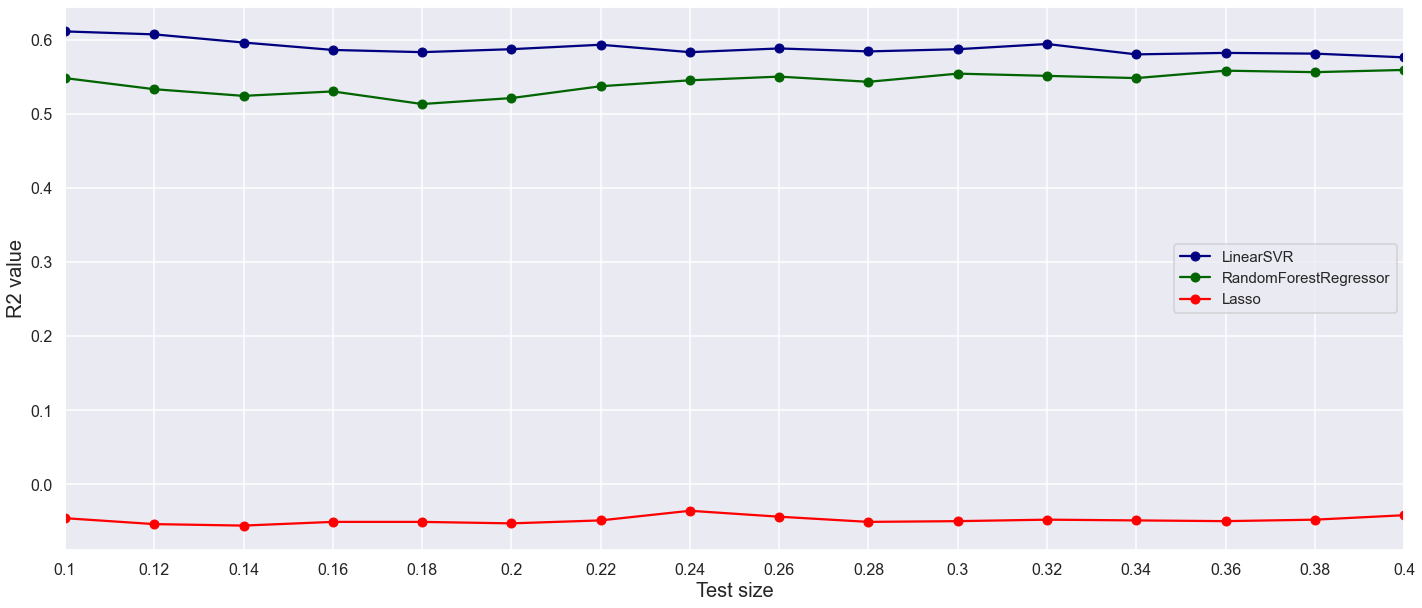

In [13]:
plt.figure(figsize=(24, 10))

test_size = df_regr_results['test_size']
regr_strings = [regr_list[i].__class__.__name__ for i in range(0, len(regr_list))]
colors = ['navy', 'darkgreen', 'red']

for regr, color in zip(regr_strings, colors):
    plt.plot(test_size, df_regr_results[regr], marker='o', color=color, label=regr)
plt.xlim((min(test_size.values), max(test_size.values)))
plt.xlabel('Test size', fontsize=20)
plt.ylabel('R2 value', fontsize=20)
plt.legend(fontsize=15)
plt.xticks(ticks=test_size.values, labels=test_size.values, fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [14]:
def plot_best_features(df, regr_name, k):
	fig, ax = plt.subplots(1, 1, figsize=(26, 20))
	sns.barplot(x="value", y="feature", data=df.head(k), 
				orient='h', palette=df.head(k)["colors"])
	ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=12)
	ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
	ax.set_title(f"Top {k} Features for '{regr_name.__class__.__name__}'", fontsize=36, pad=25)
	ax.set_ylabel("Coef", fontsize=20)
	ax.set_xlabel("Feature Name", fontsize=20)
	plt.show()


def importance_features_checking(regr_name, ratio, *k):
	X_train, X_test, y_train, y_test = split_dataset(ratio)
	# define the model
	model = Pipeline(steps=[('preprocessor', preprocessor),
							('regr', regr_name)])
	# fit the model
	model.fit(X_train, y_train)

	# Get the names of each feature
	feature_names = model.named_steps["preprocessor"].get_feature_names_out()
	# Get the coefficients of each feature
	if regr_name.__class__.__name__ == 'RandomForestRegressor':
		coefs = model.named_steps["regr"].feature_importances_.flatten()
	else:
		coefs = model.named_steps["regr"].coef_.flatten()

	# Zip coefficients and names together and make a DataFrame
	zipped = zip(feature_names, coefs)
	df = pd.DataFrame(zipped, columns=["feature", "value"])

	# Sort the features by the absolute value of their coefficient
	df["abs_value"] = df["value"].apply(lambda x: abs(x))
	df["colors"] = df["value"].apply(lambda x: "green" if x > 0 else "red")
	df = df.sort_values("abs_value", ascending=False)
	
	## If 'k' is present, it specify desired number of important features from every regressor
	if k:
		plot_best_features(df, regr_name, k)

	return df


def most_importance_features(regr_list, ratio, n):
    indexes_list = []
    ## Indexes of the 'n' the most important features for list of regressors
    for i in regr_list:
        indexes_list += list(importance_features_checking(i, ratio)['feature'][:n].index)
    ## Return unique values from concatenated lists
    return list(set(indexes_list))

### Calculate `X_train_ohe` and `X_test_ohe` with unique features only using OneHotEncoder - both variables will be used to compare r2_score results using part and full dataset.

In [15]:
def manual_features_encoding(X_train, X_test, y_train, ratio, n_features):
	# configure to select a subset of features
	ohe = OneHotEncoder(handle_unknown='ignore')
	# learn relationship from training data
	ohe.fit(X_train, y_train)
	# transform input data
	X_train_ohe, X_test_ohe = ohe.transform(X_train), ohe.transform(X_test)
	## All unique the most important features indexes
	uniques_ind = most_importance_features(regr_list, ratio, n_features)
	X_train_subset, X_test_subset = np.array(X_train_ohe.toarray())[:, uniques_ind], np.array(X_test_ohe.toarray())[:, uniques_ind]

	return X_train_subset, X_test_subset

In [ ]:
def predictions_result(regr):
    for i in df_regr_results['test_size'].values:
        X_train, X_test, y_train, y_test = split_dataset(i)
        X_train_ohe, X_test_ohe = manual_features_encoding(X_train, X_test, y_train, i, 50)
        #print('\tPredition results calculated on only the best features in dataset:')
        model = TransformedTargetRegressor(regressor=regr, transformer=QuantileTransformer(output_distribution="normal"))
        
        ## Index in Dataframe to insert r2_score value
        ind = df_regr_results[df_regr_results['test_size']==i].index
        # prepare the model with target scaling        
        model.fit(X_train_ohe, y_train)
        r2_score = model.score(X_test_ohe, y_test)
        regr_name = regr.__class__.__name__
        column_name = f'{regr_name}_subset'
        df_regr_results.loc[ind, column_name] = np.round(r2_score, 3)
    return df_regr_results

## Compare r2_score results receiving by change test_size
for val in regr_list:
    predictions_result(val)

df_regr_results

In [16]:
#df_regr_results.to_csv('regr_results_complete.csv', index_label=False)
df_regr_results = pd.read_csv('regr_results_complete.csv')

### After making complete calculations, it is time for give some graphical comparison of `r2_score` values for every regressors using full and partial (column with `'_subset'` prefix) features from Dataframe

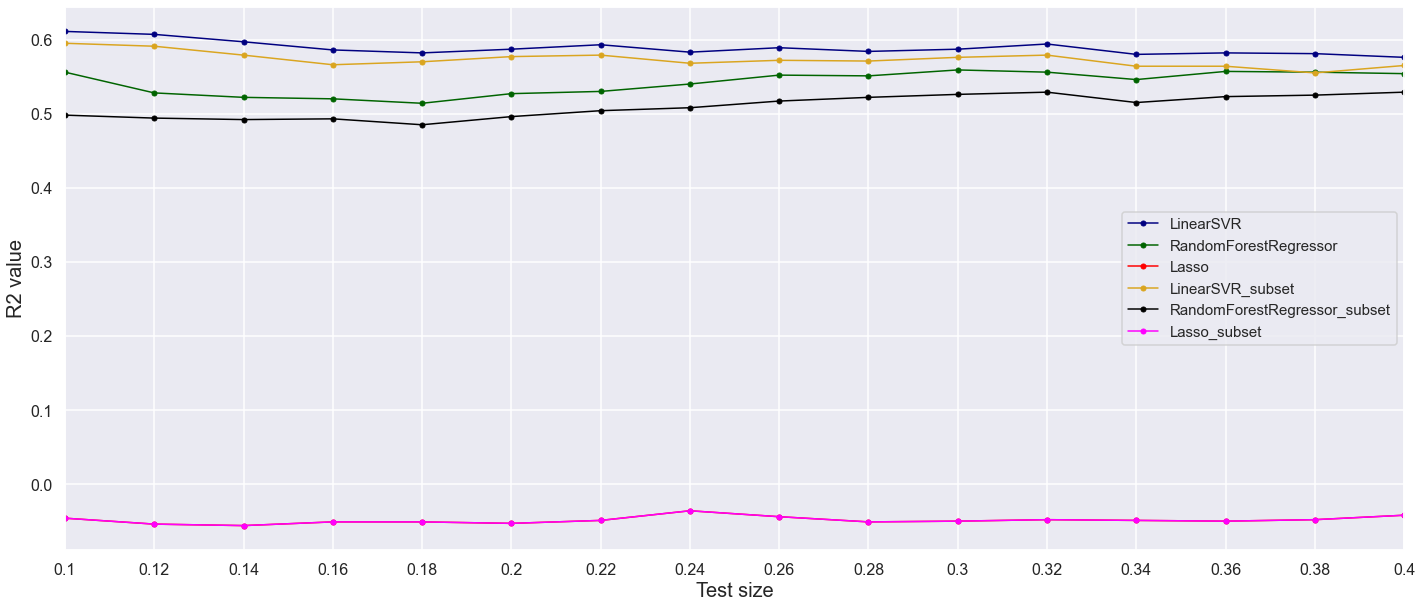

In [17]:
plt.figure(figsize=(24, 10))

test_size = df_regr_results['test_size']
regr_columns_names = list((df_regr_results.columns)[1:].values)
colors = ['navy', 'darkgreen', 'red', 'goldenrod', 'black', 'magenta']

for regr, color in zip(regr_columns_names, colors):
    plt.plot(test_size, df_regr_results[regr], marker='o', markersize=5, color=color, lw=1.5, label=regr)
plt.xlim((min(test_size.values), max(test_size.values)))
plt.xlabel('Test size', fontsize=20)
plt.ylabel('R2 value', fontsize=20)
plt.legend(fontsize=15)
plt.xticks(ticks=test_size.values, labels=test_size.values, fontsize=16)
plt.yticks(fontsize=16)
plt.show()

## **Conclusion before start tuning regressors with hyperparameters:**
### - biggest different between R2 score for the same regressor is about 3% (RandomForest), but it is occupied by huge time consumption (results for all 3 regressors with partial dataset are ready after 1 second, for full dataset it is ~80 seconds)
### - disappointed result for Lasso regressor (score is negative no matter of which prediction functions were used!!)

---

## Optimization result using tuned hyperparameters for every regressor

### Split data into train and test part and finding best features importance will be made only once (they will not be change). `'test_size'`=0.26 (after analyzing plot from above) and number of the most important features from every regressor is 50 (max. 150, but it should be finally less).

In [18]:
data_splited = split_dataset(0.26)
ohe_transf_results = manual_features_encoding(data_splited[0], data_splited[1], data_splited[2], 0.26, 50)

def regressor_results(regr_name, regr_params, *full_data):
    X_train, X_test, y_train, y_test = data_splited
    ## Take into consideration all or only the best features from Dataframe ##
    if full_data:
        transform_target = TransformedTargetRegressor(regressor=regr_name, 
                                                      transformer=QuantileTransformer(output_distribution="normal"))
        model = Pipeline(steps=[('preprocessor', preprocessor),
                                ('transform_target', transform_target)])
    else:
        # X_train_ohe, X_test_ohe calculated in manual_features_encoding()
        X_train, X_test = ohe_transf_results[0], ohe_transf_results[1]
        model = TransformedTargetRegressor(regressor=regr_name, 
                                           transformer=QuantileTransformer(output_distribution="normal"))
    
    ## Get best combinations of hyperparameters for regressor
    gridsearch = HalvingGridSearchCV(model, regr_params, scoring='r2', aggressive_elimination=True,
                                     factor=4, return_train_score=False, n_jobs=20)

    ## Calculating the best model, R2 score and predicted target (y_pred)
    best_model = gridsearch.fit(X_train, y_train)
    r2_score = best_model.score(X_test, y_test)
    y_pred = best_model.predict(X_test)
    print(f'For "{regr_name.__class__.__name__}":\nBest params:{best_model.best_params_}\nR2 score={100*r2_score:.1f}%\n')

    return best_model, y_pred

In [19]:
SVR_params = {'regressor__kernel': ['poly', 'rbf', 'sigmoid'],
              'regressor__C': np.logspace(-1, 3, 15),
              'regressor__degree': [3, 4, 5],
              'regressor__gamma': np.logspace(-4, -2, 10),
              'regressor__epsilon': np.linspace(0, 1, 5),
              'regressor__coef0': np.linspace(-2, 2, 5)}

NuSVR_params = {'regressor__kernel': ['poly', 'rbf', 'sigmoid'],
                'regressor__C': np.logspace(-1, 3, 15),
                'regressor__degree': [3, 4, 5],
                'regressor__gamma': np.logspace(-4, -2, 10),
                'regressor__nu': [0.1, 0.3, 0.5, 0.7, 0.9],
                'regressor__coef0': np.linspace(-2, 2, 5)}

LinearSVR_params = {'regressor__C': np.logspace(-4, 1, 150),
                    'regressor__epsilon': np.linspace(0, 1, 21),
                    'regressor__loss': ['epsilon_insensitive', 'squared_epsilon_insensitive']}

In [20]:
SVR_results = regressor_results(SVR(cache_size=2000, max_iter=1e9), SVR_params)

c:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(
c:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan ... -0.22898279 -2.13063793
 -1.89842912]
  warnings.warn(
c:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.28086778 0.28973581 0.28721941]
  warnings.warn(
c:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.33421276 0.33943537 0.34996844]
  warnings.warn(
c:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or

For "SVR":
Best params:{'regressor__C': 10.0, 'regressor__coef0': -2.0, 'regressor__degree': 3, 'regressor__epsilon': 0.0, 'regressor__gamma': 0.001291549665014884, 'regressor__kernel': 'poly'}
R2 score=56.0%



In [21]:
NuSVR_results = regressor_results(NuSVR(cache_size=2000, max_iter=1e9), NuSVR_params)

c:\Users\Lenovo\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
c:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(
c:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan ... -0.05709418 -0.03217522
  0.01966892]
  warnings.warn(
c:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.25109    0.26433882 0.25472106]
  warnings.warn(
c:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: 

For "NuSVR":
Best params:{'regressor__C': 5.17947467923121, 'regressor__coef0': 2.0, 'regressor__degree': 5, 'regressor__gamma': 0.01, 'regressor__kernel': 'rbf', 'regressor__nu': 0.9}
R2 score=55.2%



In [22]:
LinearSVR_results = regressor_results(LinearSVR(max_iter=1e9), LinearSVR_params)

c:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(
c:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan ... -0.32455927 -0.32257177
 -1.03103176]
  warnings.warn(
c:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.22592297 0.23388312 0.23867492]
  warnings.warn(
c:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.40890852 0.41325137 0.41529899]
  warnings.warn(


For "LinearSVR":
Best params:{'regressor__C': 0.022335377063851233, 'regressor__epsilon': 0.0, 'regressor__loss': 'squared_epsilon_insensitive'}
R2 score=54.2%



c:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.41529899 0.51479352 0.51778926]
  warnings.warn(


### The highest `r2_score` value which we see as a output of regressor_results() is not mean value calculated from all 5-fold CV, but value from one fold only, so I need to find REAL best `r2_score` value from all used regressors.

In [23]:
def find_10_best_results(regr_params, regr_results):
    orig_params_list = list(regr_params.keys())
    transformed_params_list = ['param_' + orig_params_list[i] for i in range(0, len(orig_params_list))]
    no_prefix_params_list = [orig_params_list[i].split('__')[-1] for i in range(0, len(orig_params_list))]
    
    ## Create Dataframe with 10 best results (features are: hyperparameters, r2_score and rank)
    useful_features = transformed_params_list + ['mean_test_score', 'rank_test_score']
    _ = pd.DataFrame(data = regr_results[0].cv_results_)[useful_features]
    _ = _.drop_duplicates(subset=['rank_test_score']).reset_index(drop=True)
    _ = _.nsmallest(n=10, columns='rank_test_score')

    ## Simplify columns name
    def cols_name_change(col_name):
        if col_name == 'mean_test_score':
            return 'R2'
        elif col_name == 'rank_test_score':
            return 'rank'
        else:
            # leave only name of hyperparameter (no prefixes)
            return col_name.split('__')[-1]
    
    _ = _.rename(columns=cols_name_change)

    return _[no_prefix_params_list + ['R2','rank']]

In [24]:
find_10_best_results(SVR_params, SVR_results)

,kernel,C,degree,gamma,epsilon,coef0,R2,rank
45000,poly,10.0,3,0.001292,0.0,-2.0,0.531771,1
44999,rbf,10.0,3,0.005995,0.0,-2.0,0.526106,2
45001,rbf,10.0,3,0.005995,0.25,-2.0,0.520731,3
44998,rbf,10.0,3,0.005995,0.25,-2.0,0.349968,4
44992,poly,10.0,3,0.001292,0.0,-2.0,0.341620,5
44991,rbf,10.0,3,0.005995,0.0,-2.0,0.340115,6
44997,poly,10.0,3,0.000774,0.25,-2.0,0.339435,7
44996,poly,5.179475,4,0.000464,0.25,2.0,0.334213,8
44995,rbf,5.179475,5,0.01,0.5,2.0,0.331914,9
44994,rbf,10.0,3,0.003594,0.25,-2.0,0.330214,10


In [25]:
find_10_best_results(NuSVR_params, NuSVR_results)

,kernel,C,degree,gamma,nu,coef0,R2,rank
45000,rbf,5.179475,5,0.01,0.9,2.0,0.485304,1
45001,rbf,5.179475,5,0.01,0.5,2.0,0.481720,2
45002,poly,10.0,3,0.000774,0.5,-2.0,0.478643,3
44992,poly,10.0,3,0.000774,0.5,-2.0,0.376139,4
44994,rbf,5.179475,5,0.01,0.5,2.0,0.374711,5
44996,rbf,5.179475,5,0.01,0.9,2.0,0.372471,6
44998,rbf,5.179475,5,0.01,0.7,2.0,0.370961,7
44997,poly,10.0,3,0.000774,0.9,-2.0,0.369205,8
44999,poly,10.0,3,0.000774,0.7,-2.0,0.368431,9
44993,poly,10.0,3,0.000464,0.9,-2.0,0.356269,10


In [26]:
find_10_best_results(LinearSVR_params, LinearSVR_results)

,C,epsilon,loss,R2,rank
8401,0.022335,0.0,squared_epsilon_insensitive,0.517789,1
8400,0.020675,0.0,squared_epsilon_insensitive,0.514794,2
8399,0.022335,0.0,squared_epsilon_insensitive,0.415299,3
8398,0.020675,0.0,squared_epsilon_insensitive,0.413251,4
8396,0.022335,0.05,squared_epsilon_insensitive,0.411007,5
8397,0.019137,0.0,squared_epsilon_insensitive,0.408909,6
8395,0.020675,0.05,squared_epsilon_insensitive,0.408039,7
8394,0.019137,0.05,squared_epsilon_insensitive,0.404291,8
8393,0.019137,0.1,squared_epsilon_insensitive,0.399412,9
8379,0.022335,0.0,squared_epsilon_insensitive,0.285656,10


### Graphically present 2 best regressors `r2_score` values as a 'y_test vs. y_pred' scatter plots

In [27]:
def plot_predited_results(regr_list, labels):
    y_test = split_dataset(0.26)[3]
    lists_merge = np.concatenate([regr_list[i][1] for i in range(0, len(regr_list))])
    min_value, max_value = min(np.min(lists_merge), min(y_test)), max(np.max(lists_merge), max(y_test))
    marker_shapes_list = [',', '^']
    colors = ['orange', 'blue']
    
    fig, ax = plt.subplots(figsize=(12, 12))

    for regr, marker_shape, color, label in zip(regr_list, marker_shapes_list, colors, labels):
        plt.scatter(y_test, regr[1], color=color, marker=marker_shape, alpha=0.6, s=10, label=label)
    plt.plot(y_test, y_test, c='red', lw=1.5)
    plt.xlabel('Real values', fontsize=18)
    plt.ylabel('Predicted values', fontsize=18)
    plt.xlim((min_value, max_value))
    plt.ylim((min_value, max_value))
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=14)
    plt.grid(None)
    plt.title('Predicted vs. real values', fontsize=24, pad=12)

    plt.show()

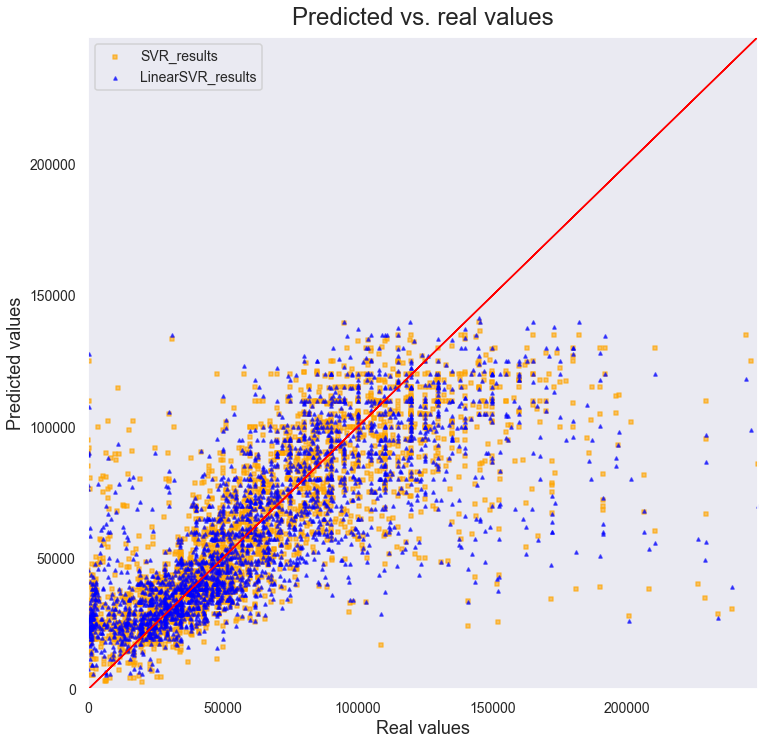

In [28]:
regr_list = [SVR_results, LinearSVR_results]
labels = ['SVR_results', 'LinearSVR_results']

plot_predited_results(regr_list, labels)

## Linear regressors tuning

In [29]:
SGDRegressor_params = {'regressor__alpha': np.logspace(-4, -2, 10),
                       'regressor__epsilon': np.arange(0.1, 1.1, 0.2),
                       'regressor__eta0': [0.01, 0.02, 0.05, 0.1, 0.2],
                       'regressor__power_t': [0.01, 0.02, 0.05, 0.1],
                       'regressor__learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
                       'regressor__loss': ['squared_loss', 'epsilon_insensitive', 'squared_epsilon_insensitive']}

Lasso_params = {'regressor__alpha': np.logspace(-4, 2, 40),
                'regressor__selection': ['cyclic', 'random'],
                'regressor__fit_intercept': [True, False]}

HuberRegressor_params = {'regressor__alpha': np.logspace(-4, 2, 30),
                         'regressor__epsilon': np.linspace(1, 10, 19),
                         'regressor__fit_intercept': [True, False]}

Ridge_params = {'regressor__alpha': np.logspace(-5, 2, 70),
                'regressor__fit_intercept': [True, False]}

In [30]:
SGDRegressor_results = regressor_results(SGDRegressor(fit_intercept=False, warm_start=True), SGDRegressor_params)

c:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(
c:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan ... -2.35925643 -1.02037825
 -4.30582894]
  warnings.warn(
c:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.17024528 0.07259988 0.18955834]
  warnings.warn(
c:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.47194825 0.47736887 0.48475909]
  warnings.warn(
c:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or

For "SGDRegressor":
Best params:{'regressor__alpha': 0.000774263682681127, 'regressor__epsilon': 0.7000000000000001, 'regressor__eta0': 0.01, 'regressor__learning_rate': 'adaptive', 'regressor__loss': 'epsilon_insensitive', 'regressor__power_t': 0.02}
R2 score=54.9%



In [31]:
Lasso_results = regressor_results(Lasso(warm_start=True), Lasso_params)

For "Lasso":
Best params:{'regressor__alpha': 0.00701703828670383, 'regressor__fit_intercept': False, 'regressor__selection': 'random'}
R2 score=45.6%



In [32]:
HuberRegressor_results = regressor_results(HuberRegressor(max_iter=1e9, warm_start=True), HuberRegressor_params)

c:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(
c:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan ... -1.15596199 -1.15765605
 -0.01366645]
  warnings.warn(
c:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.17645027 0.11264135 0.10542928]
  warnings.warn(
c:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.51601728 0.51593507 0.51520226]
  warnings.warn(
c:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or

For "HuberRegressor":
Best params:{'regressor__alpha': 0.07880462815669913, 'regressor__epsilon': 1.5, 'regressor__fit_intercept': False}
R2 score=57.5%



In [33]:
Ridge_results = regressor_results(Ridge(max_iter=1e9), Ridge_params)

For "Ridge":
Best params:{'regressor__alpha': 2.381286194765587, 'regressor__fit_intercept': False}
R2 score=56.6%



### Presenting table with 10 best r2_score values for every regressors

In [34]:
find_10_best_results(SGDRegressor_params, SGDRegressor_results)

,alpha,epsilon,eta0,power_t,learning_rate,loss,R2,rank
15998,0.000774,0.7,0.01,0.02,adaptive,epsilon_insensitive,0.542463,1
15997,0.000774,0.7,0.01,0.01,adaptive,epsilon_insensitive,0.542146,2
15999,0.000774,0.7,0.02,0.01,invscaling,epsilon_insensitive,0.529956,3
15988,0.000774,0.7,0.02,0.01,invscaling,epsilon_insensitive,0.520933,4
15992,0.000774,0.7,0.01,0.02,adaptive,epsilon_insensitive,0.506805,5
15989,0.000774,0.7,0.01,0.01,adaptive,epsilon_insensitive,0.503610,6
15986,0.000774,0.7,0.01,0.1,adaptive,epsilon_insensitive,0.501564,7
15985,0.000774,0.7,0.01,0.05,adaptive,epsilon_insensitive,0.497014,8
15993,0.000774,0.7,0.01,0.05,invscaling,epsilon_insensitive,0.489799,9
15987,0.000774,0.7,0.02,0.1,invscaling,epsilon_insensitive,0.484811,10


In [35]:
find_10_best_results(Lasso_params, Lasso_results)

,alpha,selection,fit_intercept,R2,rank
115,0.007017,random,False,0.481251,1
116,0.007017,random,True,0.481184,2
113,0.007017,random,True,0.450951,4
114,0.007017,cyclic,False,0.450566,6
112,0.01,cyclic,True,0.421869,8
111,0.01,cyclic,False,0.420616,10
110,0.014251,random,False,0.380171,12
93,0.007017,cyclic,False,0.364684,14
92,0.007017,cyclic,True,0.363100,16
94,0.01,cyclic,True,0.351533,18


In [36]:
find_10_best_results(HuberRegressor_params, HuberRegressor_results)

,alpha,epsilon,fit_intercept,R2,rank
1519,0.078805,1.5,False,0.531405,1
1520,0.078805,1.0,True,0.520496,2
1515,0.078805,1.0,True,0.519066,3
1516,0.078805,1.5,False,0.516017,4
1517,0.078805,1.5,True,0.515935,5
1518,0.078805,1.0,False,0.515202,6
1514,0.078805,2.0,False,0.510275,7
1511,0.078805,1.0,False,0.176450,8
1509,0.078805,1.5,True,0.172934,9
1508,0.078805,1.5,False,0.172859,10


In [37]:
find_10_best_results(Ridge_params, Ridge_results)

,alpha,fit_intercept,R2,rank
185,2.381286,False,0.567507,1
184,2.381286,True,0.567494,2
186,3.007883,False,0.566874,3
180,3.007883,False,0.561067,4
181,2.381286,False,0.560808,5
182,2.381286,True,0.560680,6
179,3.007883,True,0.560656,7
177,3.799357,False,0.560564,8
178,3.799357,True,0.559843,9
183,1.885221,False,0.559204,10


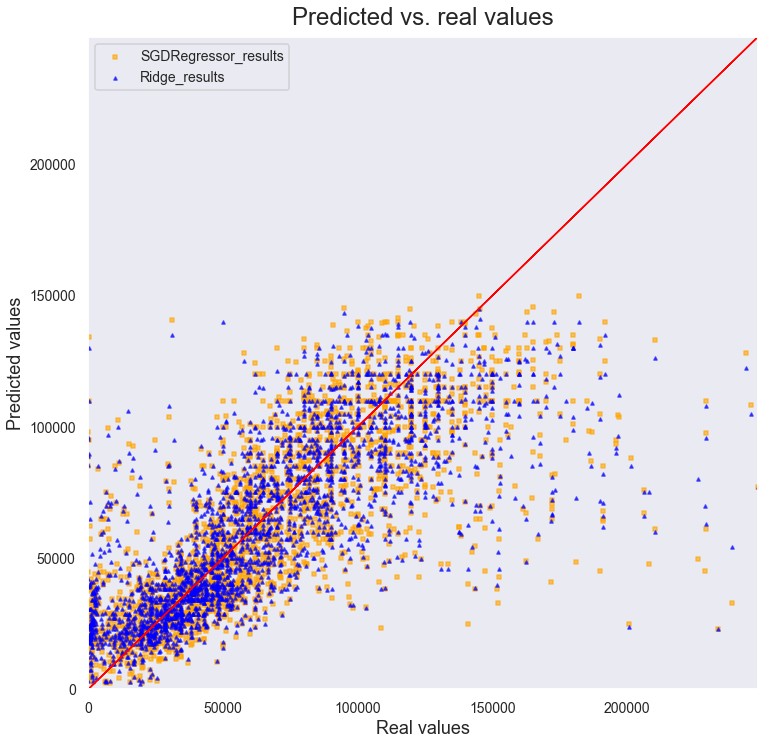

In [38]:
regr_list = [SGDRegressor_results, Ridge_results]
labels = ['SGDRegressor_results', 'Ridge_results']

plot_predited_results(regr_list, labels)

## Tree-based regressors tuning

In [39]:
RandomForest_params = {'regressor__n_estimators': range(50, 525, 25),
                       'regressor__min_samples_split': [2, 3],
                       'regressor__min_samples_leaf': [1, 2]}

ExtraTrees_params = {'regressor__n_estimators': range(50, 525, 25),
                     'regressor__min_samples_split': [2, 3],
                     'regressor__min_samples_leaf': [1, 2]}

XGBRegressor_params = {'regressor__eta': np.logspace(-3, -1, 10),
                       'regressor__gamma': np.arange(0, 12, 2)}

In [40]:
RandomForest_results = regressor_results(RandomForestRegressor(warm_start=True, random_state=42), RandomForest_params)

For "RandomForestRegressor":
Best params:{'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 3, 'regressor__n_estimators': 175}
R2 score=52.7%



In [41]:
ExtraTrees_results = regressor_results(ExtraTreesRegressor(bootstrap=True, warm_start=True, random_state=42), ExtraTrees_params)

For "ExtraTreesRegressor":
Best params:{'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 3, 'regressor__n_estimators': 325}
R2 score=53.0%



In [42]:
XGBRegressor_results = regressor_results(XGBRegressor(), XGBRegressor_params)

c:\Users\Lenovo\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


For "XGBRegressor":
Best params:{'regressor__eta': 0.1, 'regressor__gamma': 2}
R2 score=54.2%



In [43]:
find_10_best_results(RandomForest_params, RandomForest_results)

,n_estimators,min_samples_split,min_samples_leaf,R2,rank
82,175,3,1,0.512336,1
81,250,2,1,0.507668,2
80,175,3,1,0.489275,3
78,250,2,1,0.488007,4
76,225,2,1,0.487198,5
79,175,2,1,0.486696,6
77,200,2,1,0.486216,7
5,175,2,1,0.443415,8
15,425,2,1,0.442851,9
12,350,2,1,0.442806,10


In [44]:
find_10_best_results(ExtraTrees_params, ExtraTrees_results)

,n_estimators,min_samples_split,min_samples_leaf,R2,rank
82,325,3,1,0.511305,1
81,375,3,1,0.511166,2
76,325,3,1,0.457660,3
77,375,3,1,0.457121,4
80,350,3,1,0.457073,5
79,250,3,1,0.456481,6
78,275,3,1,0.456029,7
62,350,3,1,0.394623,8
63,250,3,1,0.394468,9
61,275,3,1,0.393914,10


In [45]:
find_10_best_results(XGBRegressor_params, XGBRegressor_results)

,eta,gamma,R2,rank
77,0.1,2,0.537848,1
78,0.059948,2,0.527835,2
75,0.059948,4,0.526959,3
76,0.035938,2,0.512792,4
74,0.059948,2,0.480136,5
73,0.1,2,0.473987,6
72,0.035938,2,0.470055,7
62,0.059948,4,0.465902,8
61,0.035938,4,0.464888,9
70,0.1,0,0.464282,10


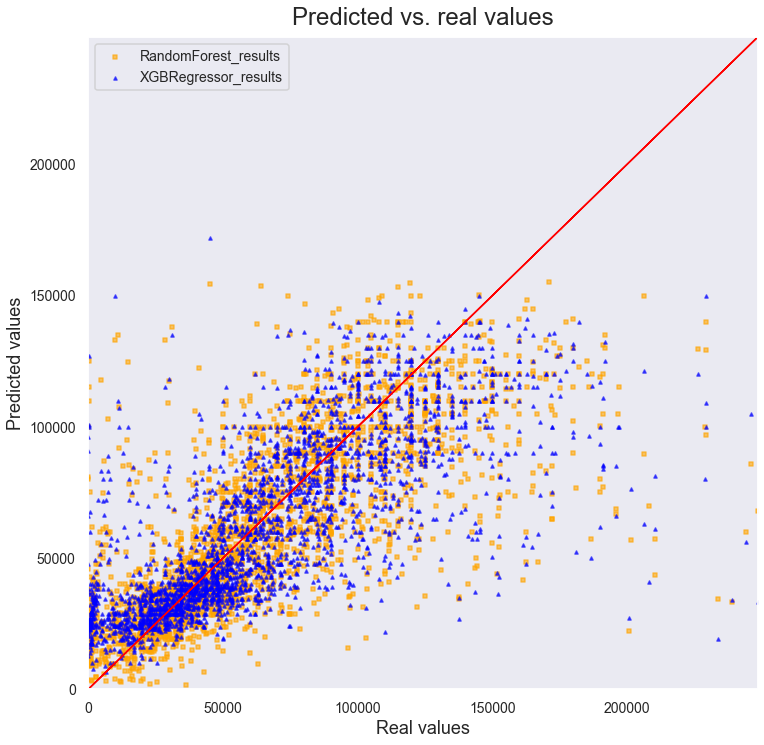

In [46]:
regr_list = [RandomForest_results, XGBRegressor_results]
labels = ['RandomForest_results', 'XGBRegressor_results']

plot_predited_results(regr_list, labels)

## K-neighbors regressors tuning

In [47]:
knn_params = {'regressor__n_neighbors': np.arange(3, 31, 1),
              'regressor__weights': ['uniform', 'distance'],
              'regressor__leaf_size': np.arange(2, 11, 1),
              'regressor__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

In [48]:
knn_results = regressor_results(KNeighborsRegressor(), knn_params)

c:\Users\Lenovo\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
c:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(
c:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan ... -0.14621527 -0.23656177
 -0.13195589]
  warnings.warn(
c:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.15491389 0.149281   0.149281  ]
  warnings.warn(
c:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: 

For "KNeighborsRegressor":
Best params:{'regressor__algorithm': 'ball_tree', 'regressor__leaf_size': 9, 'regressor__n_neighbors': 28, 'regressor__weights': 'distance'}
R2 score=30.2%



### Unsatisfactory result for KNeighbors regressor excludes it from further analysis.

---

## Final analysis

### Comparing the effectiveness of the algorithms, one of each type (SVR, linear, tree-based), measured as **r2_score/time execution** (more details are inside function below)

In [49]:
best_SVR_result = find_10_best_results(SVR_params, SVR_results).iloc[0, :]
best_Ridge_result = find_10_best_results(Ridge_params, Ridge_results).iloc[0, :]
best_XGB_result = find_10_best_results(XGBRegressor_params, XGBRegressor_results).iloc[0, :]

In [50]:
best_SVR_result.to_csv('SVR_result.csv')
best_Ridge_result.to_csv('Ridge_result.csv')
best_XGB_result.to_csv('XGB_result.csv')

In [52]:
SVR_params_full = {'transform_target__regressor__kernel': ['poly', 'rbf', 'sigmoid'],
                   'transform_target__regressor__C': np.logspace(-1, 3, 15),
                   'transform_target__regressor__degree': [3, 4, 5],
                   'transform_target__regressor__gamma': np.logspace(-4, -2, 10),
                   'transform_target__regressor__epsilon': np.linspace(0, 1, 5),
                   'transform_target__regressor__coef0': np.linspace(-2, 2, 5)}

Ridge_params_full = {'transform_target__regressor__alpha': np.logspace(-5, 2, 70),
                     'transform_target__regressor__fit_intercept': [True, False]}

XGBRegressor_params_full = {'transform_target__regressor__eta': np.logspace(-3, -1, 10),
                            'transform_target__regressor__gamma': np.arange(0, 12, 2)}


## Last parameter is boolean value used as a 'switch' if we need ('full_data'==True) or not 
## the full features from dataset to make predictions
SVR_result_full_dataset = regressor_results(SVR(cache_size=2000, max_iter=1e9), SVR_params_full, True)
Ridge_result_full_dataset = regressor_results(Ridge(max_iter=1e9), Ridge_params_full, True)
XGB_result_full_dataset = regressor_results(XGBRegressor(), XGBRegressor_params_full, True)

c:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(
c:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan ... -0.12367546 -1.01307088
 -0.67656701]
  warnings.warn(
c:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.19573614 0.16355417 0.17509979]
  warnings.warn(
c:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.42087983 0.43745607 0.42762132]
  warnings.warn(
c:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or

For "SVR":
Best params:{'transform_target__regressor__C': 10.0, 'transform_target__regressor__coef0': -2.0, 'transform_target__regressor__degree': 3, 'transform_target__regressor__epsilon': 0.25, 'transform_target__regressor__gamma': 0.002154434690031882, 'transform_target__regressor__kernel': 'rbf'}
R2 score=55.6%

For "Ridge":
Best params:{'transform_target__regressor__alpha': 7.656988080124204, 'transform_target__regressor__fit_intercept': False}
R2 score=58.1%



c:\Users\Lenovo\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


For "XGBRegressor":
Best params:{'transform_target__regressor__eta': 0.1, 'transform_target__regressor__gamma': 2}
R2 score=55.3%



In [53]:
best_SVR_result_full_dataset = find_10_best_results(SVR_params_full, SVR_result_full_dataset).iloc[0, :]
best_Ridge_result_full_dataset = find_10_best_results(Ridge_params_full, Ridge_result_full_dataset).iloc[0, :]
best_XGB_result_full_dataset = find_10_best_results(XGBRegressor_params_full, XGB_result_full_dataset).iloc[0, :]

In [54]:
best_SVR_result_full_dataset.to_csv('SVR_result_full_dataset.csv')
best_Ridge_result_full_dataset.to_csv('Ridge_result_full_dataset.csv')
best_XGB_result_full_dataset.to_csv('XGB_result_full_dataset.csv')

In [81]:
def profits_from_using_features_subset(df):
    '''
        Function used to estimate if there is a sense of making predictions performed on the most
        important features in dataset.
        
        As a measurement unit I take comparison of r2_score for prediction made on partial dataset 
        and full dataset (r2_score_1, r2_score_2) with time spending on getting these results (time_1, time_2).
    '''
    
    for num in np.arange(len(df)):
        if num % 2 != 0:
            ## difference between test scores will be presented in percent
            r2_score_1, r2_score_2 = df.loc[num-1, 'mean_test_score'], df.loc[num, 'mean_test_score']
            diff = 100 * (r2_score_2 - r2_score_1)
            
            time_1, time_2 = df.loc[num-1, 'total time'], df.loc[num, 'total time']
            divide = time_2 / time_1

            ## Results of below conditions will decided about
            ## sense of using specific regressor on partial dataset
            if diff > 2:
                if divide <= 2:
                    df.loc[num-1, 'performance'] = f"Average"
                elif (divide > 2) & (divide <= 5):
                    df.loc[num-1, 'performance'] = f"Good"
                elif (divide > 5) & (divide <= 10):
                    df.loc[num-1, 'performance'] = f"Very good"
                else:
                    df.loc[num-1, 'performance'] = "Excellent"
            elif (diff >= 0) & (diff <= 2):
                if divide <= 2:
                    df.loc[num-1, 'performance'] = f"Good"
                elif (divide > 2) & (divide <= 5):
                    df.loc[num-1, 'performance'] = f"Very good"
                else:
                    df.loc[num-1, 'performance'] = f"Excellent"
            elif (diff >= -2) & (diff < 0):
                if divide <= 2:
                    df.loc[num-1, 'performance'] = f"Good"
                elif (divide > 2) & (divide <= 5):
                    df.loc[num-1, 'performance'] = f"Very good"
                else:
                    df.loc[num-1, 'performance'] = f"Excellent"
            ## If result from partial dataset is better from full dataset of more than 2%...
            else:
                if divide <= 1.5:
                    df.loc[num-1, 'performance'] = f"Good"
                elif (divide > 1.5) | (divide <= 5):
                    df.loc[num-1, 'performance'] = f"Very good"
                else:
                    df.loc[num-1, 'performance'] = f"Excellent"

            df.loc[num, 'performance'] = "n/a"
        
    return df['performance']



def test_best_algorithms():
    """
    A custom function designed for compare r2_score values on part and all the dataset
    for the following algorithms: "SVR", "Ridge" and "XGBoost"
     
    The output of this function is a pandas dataframe.
    """
    
    ## Initiate necessary lists to insert into Dataframe
    names = ["SVR_partial", "SVR_full", "Ridge_partial", "Ridge_full", "XGBoost_partial", "XGBoost_full"]
    reg_columns = ['mean_fit_time', 'mean_score_time', 'mean_test_score', 'rank_test_score']
    
    reg_performance = pd.DataFrame(index=range(len(names)), 
                                   columns=['algorithm'] + reg_columns + ['total time', 'performance'])
    ## Fill 'algorithm' column with their names from list above 
    reg_performance['algorithm'] = names
    
    ## Results of hyperparameters tuning for "SVR", "HuberRegressor" and "XGBoost"
    results_names_list = [SVR_results, SVR_result_full_dataset, Ridge_results, 
                          Ridge_result_full_dataset, XGBRegressor_results, XGB_result_full_dataset]
    
    for name, result in zip(names, results_names_list):
        ## We need only information about: total time, r2_score and rank number
        ## from every 3 regressors using partial and all features.
        _ = pd.DataFrame(data = result[0].cv_results_)[reg_columns]

        ## Finding index (position) of algorithm name
        i = reg_performance[reg_performance['algorithm'] == name].index
        
        ## Time of regressor fitting and calculating the r2_score
        total_time = np.sum(_['mean_fit_time']) + np.sum(_['mean_score_time'])

        if total_time <= 10:
            reg_performance.loc[i, 'total time'] = np.round(total_time, 3)
        elif (total_time >= 10) & (total_time <= 100):
            reg_performance.loc[i, 'total time'] = np.round(total_time, 2)
        else:
            reg_performance.loc[i, 'total time'] = np.round(total_time, 1)

        best_r2_score = _.loc[_["rank_test_score"]==1, "mean_test_score"].iloc[0]
        reg_performance.loc[i, 'mean_test_score'] = np.round(best_r2_score, 4)

        ## Change Index number to number to use it in function
        reg_performance['performance'] = profits_from_using_features_subset(reg_performance)
        
    reg_performance = reg_performance.drop(columns=['mean_fit_time', 'mean_score_time', 'rank_test_score'], axis=1)
    
    return reg_performance
    

reg_performance = test_best_algorithms()
reg_performance

,algorithm,mean_test_score,total time,performance
0,SVR_partial,0.5318,409.3,Very good
1,SVR_full,0.5217,1497.5,n/a
2,Ridge_partial,0.5675,1.742,Very good
3,Ridge_full,0.5854,7.931,n/a
4,XGBoost_partial,0.5378,303.6,Good
5,XGBoost_full,0.5525,371.7,n/a


In [19]:
#reg_performance.to_csv('final_compare.csv')

## **2) Predict missing values in the target column using the best regressor model with its parameters**

In [4]:
best_Ridge_full_dataset_performance = pd.read_csv('Ridge_result_full_dataset.csv', index_col=False)
best_Ridge_full_dataset_performance

,Unnamed: 0,186
0,alpha,7.656988080124204
1,fit_intercept,False
2,R2,0.5853774882013265
3,rank,1


In [5]:
param_1 = best_Ridge_full_dataset_performance.iloc[0, 1]
param_2 = best_Ridge_full_dataset_performance.iloc[1, 1]

best_Ridge_parameters = Ridge(max_iter=1e9, alpha=float(param_1), fit_intercept=param_2)

### ***df*** Dataframe with all the data (missing values also) will be split into train and test parts - np.Nan values wil be save as `y_test` column.

In [7]:
## split into separated Dataframes non-missing and missing values as 'df_no_nan', 'df_nan'
df_no_nan = df.dropna(how='any')
df_nan = df[df.isnull().any(axis=1)]

X_train_full, X_test_full = df_no_nan.drop(['Salary'], axis=1).astype('category'), df_nan.drop(['Salary'], axis=1).astype('category')
y_train_full, y_test_full = df_no_nan['Salary'], df_nan['Salary']

In [8]:
def manual_all_features_encoding(X_train_full, X_test_full, y_train_full):
    # configure to select a subset of features
	ohe = OneHotEncoder(handle_unknown='ignore')
	# learn relationship from training data
	ohe.fit(X_train_full, y_train_full)
	# transform input data
	X_train_ohe, X_test_ohe = ohe.transform(X_train_full), ohe.transform(X_test_full)

	return X_train_ohe, X_test_ohe

### Find missing target values 

In [9]:
ohe_transf_results = manual_all_features_encoding(X_train_full, X_test_full, y_train_full)

def missing_values_prediction(regr_name):
    # X_train_ohe, X_test_ohe calculated in manual_all_features_encoding()
    X_train, X_test = ohe_transf_results[0], ohe_transf_results[1]
    model = TransformedTargetRegressor(regressor = regr_name, 
                                       transformer = QuantileTransformer(output_distribution="normal"))    

    ## Calculating the best model and predicted target (y_pred)
    best_model = model.fit(X_train, y_train_full)
    y_pred = best_model.predict(X_test)
    
    return y_pred


y_test_Ridge = missing_values_prediction(best_Ridge_parameters).round(2)

## Our missing salaries in target column
y_test_Ridge

array([ 20146.05, 111853.16,  99974.54, ...,  13281.36,  19114.74,
        57007.87])

In [10]:
def fill_df():
    _ = pd.DataFrame(data={'Salary': pd.Series(y_test_Ridge, dtype='float')})
    _.set_index(y_test_full.index, inplace=True)
    return _


def df_missing_fill():
    pred_y = fill_df()
    ## Join two Series into Dataframe with 2 columns
    df_con = pd.concat([y_train_full, pred_y], axis=0)
    ## Replace missed values in 'Salary' column (target)
    ## with predicted values (pred_y)
    for i in range(0, len(df_con)):
        if pd.isna(df_con.loc[i,'Salary']):
            df_con.loc[i,'Salary'] = df_con.loc[i,0]
        else:
            pass
    ## We need only 'Salary' column from Dataframe above
    return df_con['Salary']


all_salaries = df_missing_fill()
all_salaries

1         88349.62
9         77670.00
10       130000.00
11        82500.00
15       100764.00
           ...    
30740     66763.44
30741     31474.19
30742     13281.36
30743     19114.74
30745     57007.87
Name: Salary, Length: 30746, dtype: float64

### Comparison distribution in 'Salary' column before filling it with missing data and after making this.

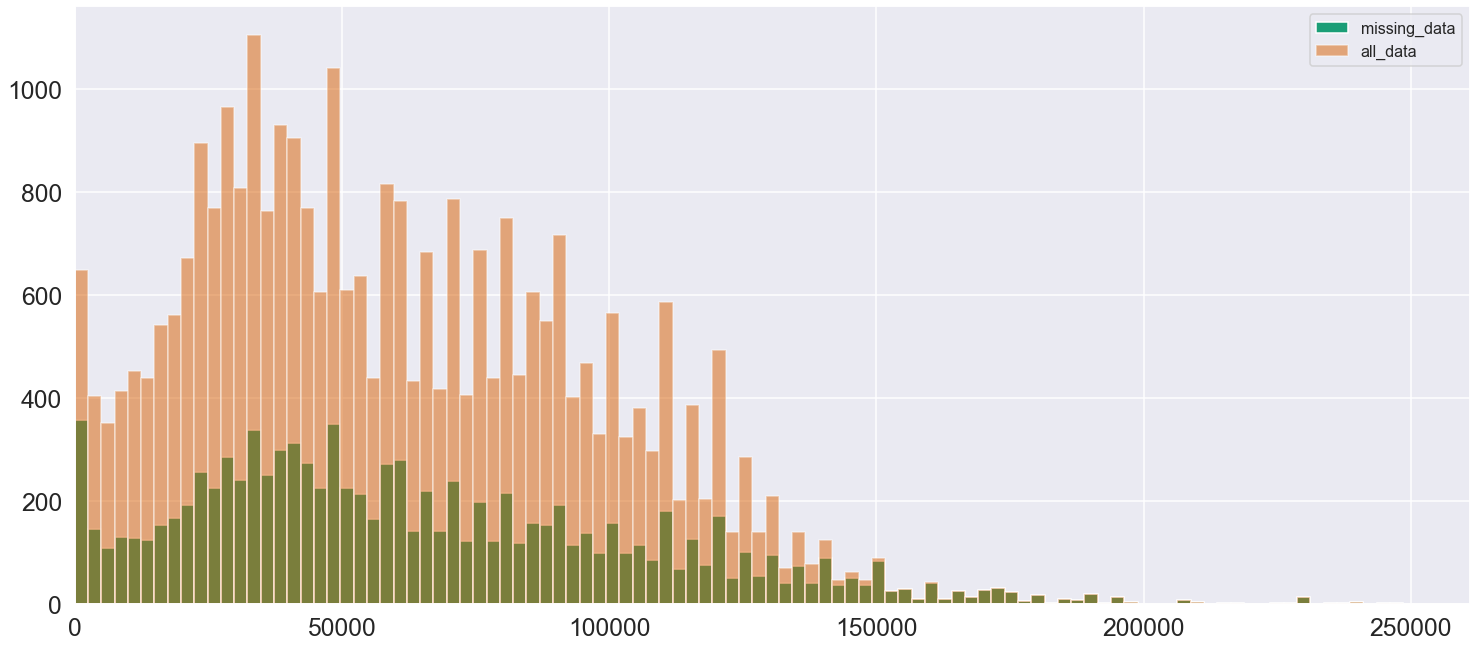

In [21]:
fig = plt.subplots(figsize=(25, 11))

sns.set_theme(context='talk', font_scale=1.5, palette='Dark2')

for col_name, alpha, label in zip([df['Salary'], all_salaries], [1, 0.5], ['missing_data', 'all_data']):
    plt.hist(x=col_name, bins=100, alpha=alpha, label=label)
plt.xlim(left=0)
plt.legend(fontsize=16)
plt.show()

### Replacing target column by column which includes all salaries values

In [22]:
df['Salary'] = all_salaries

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30746 entries, 0 to 30745
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Professional        30746 non-null  object 
 1   ProgramHobby        30746 non-null  object 
 2   Country             30746 non-null  object 
 3   University          30746 non-null  object 
 4   EmploymentStatus    30746 non-null  object 
 5   FormalEducation     30746 non-null  object 
 6   MajorUndergrad      30746 non-null  object 
 7   HomeRemote          30746 non-null  object 
 8   CompanySize         30746 non-null  object 
 9   CompanyType         30746 non-null  object 
 10  YearsProgram        30746 non-null  object 
 11  YearsCodedJob       30746 non-null  object 
 12  CareerSatisfaction  30746 non-null  float64
 13  JobSatisfaction     30746 non-null  float64
 14  Gender              30746 non-null  object 
 15  Race                30746 non-null  object 
 16  Deve